## Import modules

In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

## Configuration class

In [2]:
class Config:
    seed = 44
    n_epochs = 200
    batch_size = 32
    dropout_rate = 0.3
    latent_space_dim = 2
        
    validation_rate = 0.2
    
    image_size = 28
    channels = 1
    
    
    optimizer = Adam(lr=1e-4)
    r_loss_factor = 10000
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  mode='auto',
                                  factor=0.8,
                                  patience=2,
                                  min_delta=1e-4,
                                  coldown=5,
                                  min_lr=1e-5,
                                  verbose=1)
    
    checkpoint_best = ModelCheckpoint('best_model.h5',
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      save_best_only=True,
                                      save_weights_only=False)
    
    checkpoint_last = ModelCheckpoint('last_model.h5',
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      save_best_only=False,
                                      save_weights_only=False)
    
    early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=8)
    
    callbacks = [reduce_lr, checkpoint_best, checkpoint_last, early_stop]

In [3]:
config = Config()

## Data load

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, config.image_size * config.image_size)
x_test = x_test.reshape(-1, config.image_size * config.image_size)

11493376/11490434 [==============================] - 0s 0us/step



## Model architecture

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, BatchNormalization, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Lambda, UpSampling2D, Reshape

from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    
    epsilon = K.random_normal(shape=(batch, config.latent_space_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
def VAE(input_shape=(config.image_size * config.image_size,)):

    input_encoder = Input(shape=(input_shape))
    x = Dense(256, activation='relu')(input_encoder)

    latent_mu = Dense(config.latent_space_dim, name='latent_mean')(x)
    latent_log_var = Dense(config.latent_space_dim, name='latent_log_var')(x)
    latent_sample = Lambda(sampling)([latent_mu, latent_log_var])

    encoder = Model(input_encoder, [latent_mu, latent_log_var, latent_sample], name='encoder')

    latent_input = Input(shape=(config.latent_space_dim,), name='decoder_input')

    x = Dense(256, activation='relu')(latent_input)
    output_decoder = Dense(input_shape[0], activation='sigmoid')(x)

    decoder = Model(latent_input, output_decoder, name='decoder')

    output_vae = decoder(encoder(input_encoder)[2])
    vae = Model(input_encoder, output_vae, name ='vae')


    reconstruction_loss = binary_crossentropy(input_encoder, output_vae) * (config.image_size * config.image_size)
    reconstruction_loss = K.mean(reconstruction_loss)

    kl_loss = 1 + latent_log_var - K.square(latent_mu) - K.exp(latent_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    vae_loss = K.mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)  
    vae.add_metric(reconstruction_loss, name='reconstruction_loss')
    vae.add_metric(kl_loss, name='kl_divergence_loss')

    vae.compile(optimizer=config.optimizer)
    vae.build(input_shape=(None, config.image_size * config.image_size))

    return vae, encoder, decoder

In [10]:
vae, encoder, decoder = VAE()

In [11]:
encoder.summary()
decoder.summary()
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

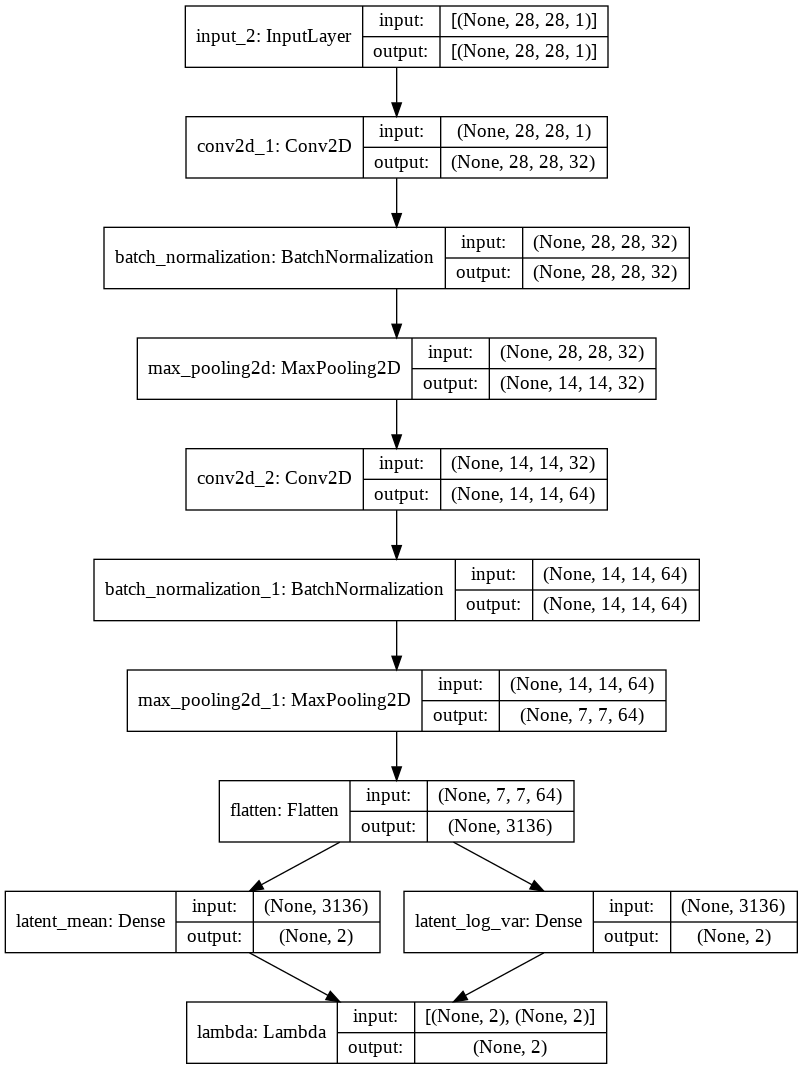

In [12]:
plot_model(encoder,to_file='encoder.png', show_shapes=True, show_layer_names=True)

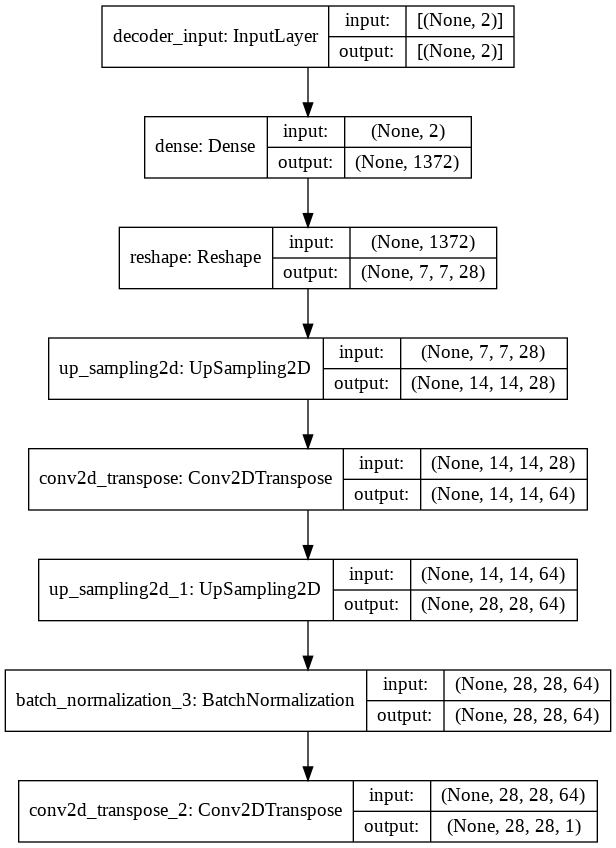

In [13]:
plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
if os.path.isfile("best_model.h5"):
    vae.load_weights('best_model.h5')

In [ ]:
vae.fit(x_train, x_train,
        validation_data=(x_test, x_test),
        epochs=config.n_epochs,
        batch_size=config.batch_size,
        callbacks=config.callbacks,
        shuffle=True)

In [ ]:
vae.load_weights('./best_model.h5')

## Reconstruction result

In [ ]:
import numpy as np
data = x_test[:20]

fig = plt.figure(figsize=(30, 10))
for n in range(0, 20, 2):
    image = vae.predict(np.expand_dims(data[n], axis=0))
    
    plt.subplot(2, 10, n + 1)
    plt.imshow(data[n].reshape(28, 28))
    plt.title('original image')
    
    plt.subplot(2, 10, n + 2)
    plt.imshow(np.reshape(image, (28, 28)))
    plt.title('reconstruct')
    
plt.show()

## Generation new digits

In [ ]:
n_show_new_images = 60
random_codes = np.random.normal(size=(n_show_new_images, config.latent_space_dim))
new_faces = decoder.predict(np.array(random_codes))

fig = plt.figure(figsize=(30, 15))
#fig.subplots_adjust(hspace=0.1, wspace=0.3)

for i in range(n_show_new_images):
    ax = fig.add_subplot(6, 10, i+1)
    ax.imshow(new_faces[i].reshape(28, 28))
    ax.axis('off')
plt.show()

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
from scipy.stats import norm
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()